In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 1.2
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 1.2)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((1.2 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[4:117].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        SMPS[key][bin] = pd.to_numeric(SMPS[key][bin]) * bin_width

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

In [4]:
print(OPS_APS['20241016_APS'].keys()[7:53])
print(SMPS['20241017_SMPS'].keys()[4:109])

Index(['0.777', '0.835', '0.898', '0.965', '1.037', '1.114', '1.197', '1.286',
       '1.382', '1.486', '1.596', '1.715', '1.843', '1.981', '2.129', '2.288',
       '2.458', '2.642', '2.839', '3.051', '3.278', '3.523', '3.786', '4.068',
       '4.371', '4.698', '5.048', '5.425', '5.829', '6.264', '6.732', '7.234',
       '7.774', '8.354', '8.977', '9.647', '10.37', '11.14', '11.97', '12.86',
       '13.82', '14.86', '15.96', '17.15', '18.43', '19.81'],
      dtype='object')
Index([' 17.5', ' 18.1', ' 18.8', ' 19.5', ' 20.2', ' 20.9', ' 21.7', ' 22.5',
       ' 23.3', ' 24.1',
       ...
       '532.8', '552.3', '572.5', '593.5', '615.3', '637.8', '661.2', '685.4',
       '710.5', '736.5'],
      dtype='object', name=0, length=105)


In [4]:
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_APS_number, SMPS_APS_mass, SMPS_APS_keys, SMPS_APS_bin_mean = merge_data(SMPS, SMPS_dict_keys, [4, 109], OPS_APS, APS_dict_keys, [7, 53], time_wBG, ['Time', 'Time'], True, False)

NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True)

SMPS_OPS_number, SMPS_OPS_mass, SMPS_OPS_keys, SMPS_OPS_bin_mean = merge_data(SMPS, SMPS_dict_keys, [4, 89], OPS_APS, dict_keys, [2, 17], time_wBG, ['Time', 'Time'], True, True)

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_small['Time'] = pd.to_datetime(df_small.index)
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_small['Time'] = pd.to_datetime(df_small.index)
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [5]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

ax_labels = ['Particle diameter / $\mu$m', 'Number / #/cm$^{3}$', 'Mass / $\mu$g/m$^{3}$']

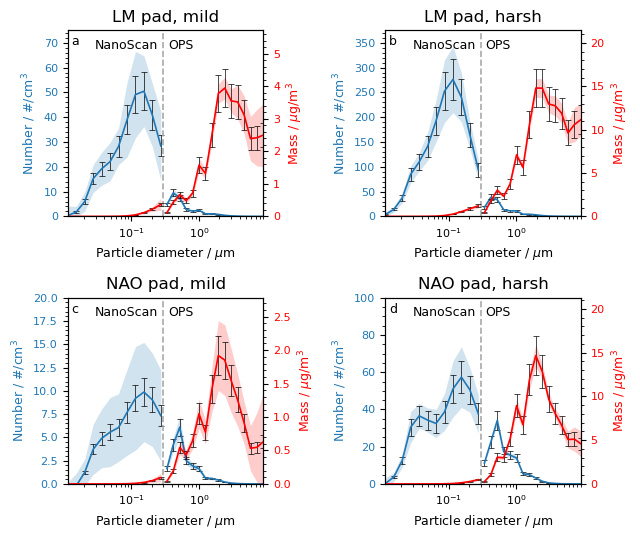

In [7]:
titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, mild', 'NAO pad, harsh']
fig, axes = plt.subplots(2, 2, figsize = (6.5, 5.5))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
        y_max = 75
    if i == 1:
        ax = axes[0][1]
        y_max = 375
    if i == 2:
        ax = axes[1][0]
        y_max = 20
    if i == 3:
        ax = axes[1][1]
        y_max = 100

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], NS_OPS_number[key], NS_OPS_mass[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, ['tab:blue', 'red'], 0.15, ax_labels, True, 0.3)
    ax.vlines(0.3, 0, 400, colors = 'darkgrey', linestyles = '--')
    ax.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
    ax.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

    ax.set_ylim(0, y_max)
    ax2.set_ylim(0, max(mass) + 0.45*max(mass))

    ax.set_title(titles[i])

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/Nano_OPS_mean.png', dpi = 600)

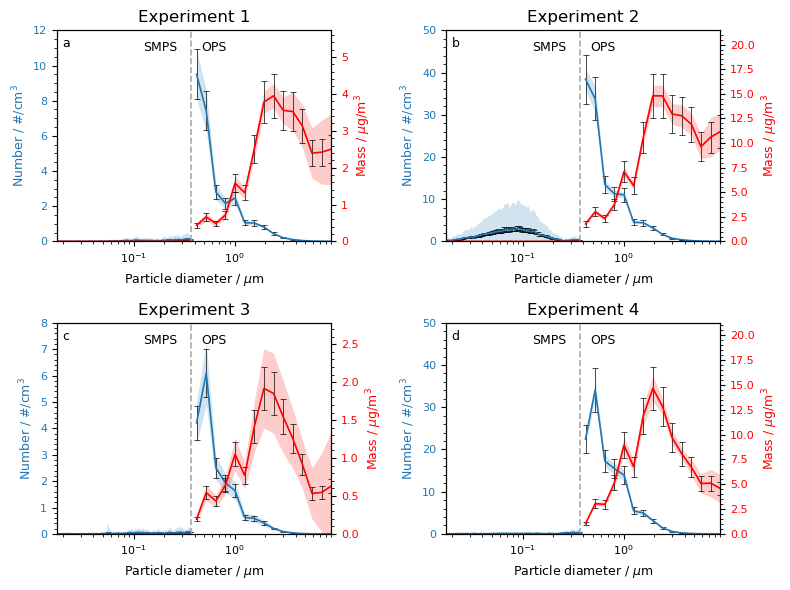

In [8]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
        y_max = 12
    if i == 1:
        ax = axes[0][1]
        y_max = 50
    if i == 2:
        ax = axes[1][0]
        y_max = 8
    if i == 3:
        ax = axes[1][1]
        y_max = 50

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS_OPS_number[key], SMPS_OPS_mass[key], SMPS_OPS_keys, 'Time', SMPS_OPS_bin_mean, ['tab:blue', 'red'], 0.15, ax_labels, True, 0.37)
    ax.vlines(0.37, 0, 400, colors = 'darkgrey', linestyles = '--')
    ax.text(0.27, y_max - 0.1*y_max, 'SMPS', ha = 'right', fontsize = 9)
    ax.text(0.47, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

    ax.set_ylim(0, y_max)
    ax2.set_ylim(0, max(mass) + 0.45*max(mass))
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_OPS_mean.png', dpi = 600)

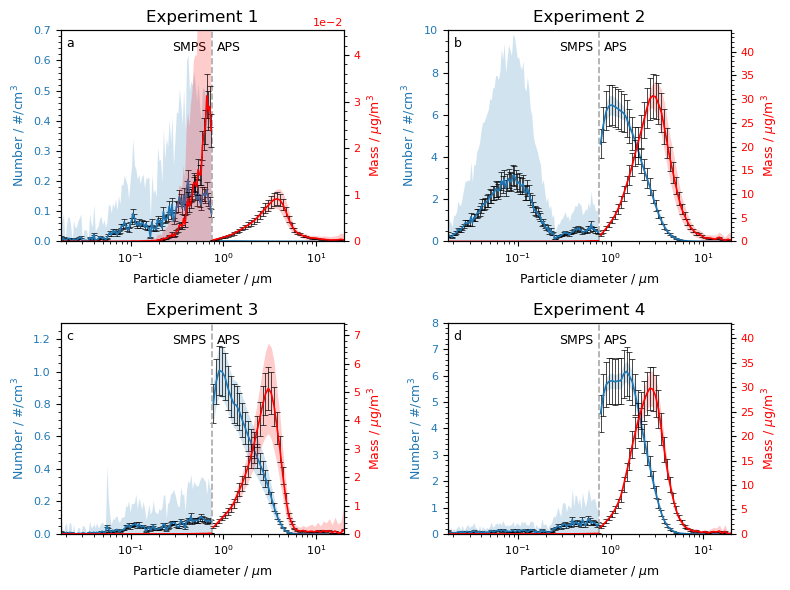

In [9]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
        y_max = 0.7
    if i == 1:
        ax = axes[0][1]
        y_max = 10
    if i == 2:
        ax = axes[1][0]
        y_max = 1.3
    if i == 3:
        ax = axes[1][1]
        y_max = 8

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS_APS_number[key], SMPS_APS_mass[key], SMPS_APS_keys, 'Time', SMPS_APS_bin_mean, ['tab:blue', 'red'], 0.15, ax_labels, True, 0.75)
    ax.vlines(0.75, 0, 40, colors = 'darkgrey', linestyles = '--')
    ax.text(0.65, y_max - 0.1*y_max, 'SMPS', ha = 'right', fontsize = 9)
    ax.text(0.85, y_max - 0.1*y_max, 'APS', ha = 'left', fontsize = 9)

    ax.set_ylim(0, y_max)
    ax2.set_ylim(0, max(mass) + 0.45*max(mass))
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_APS_mean.png', dpi = 600)

In [6]:
NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


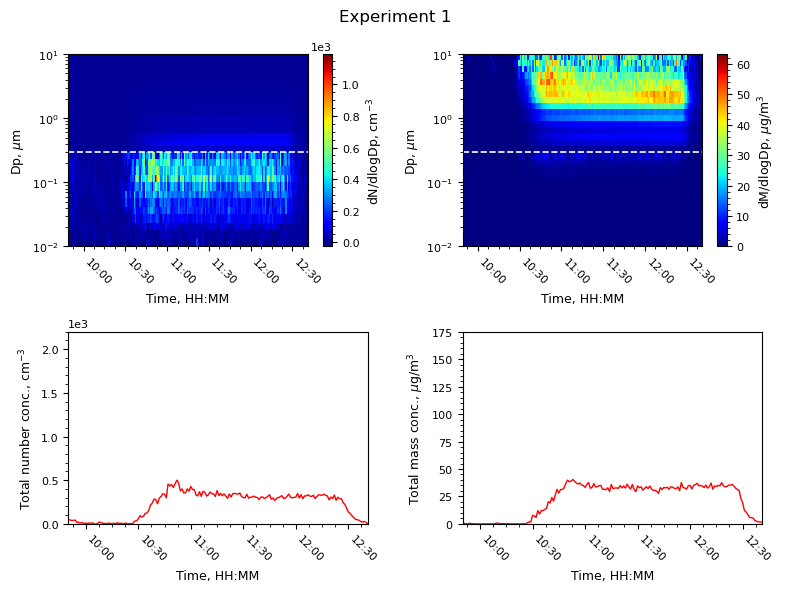

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


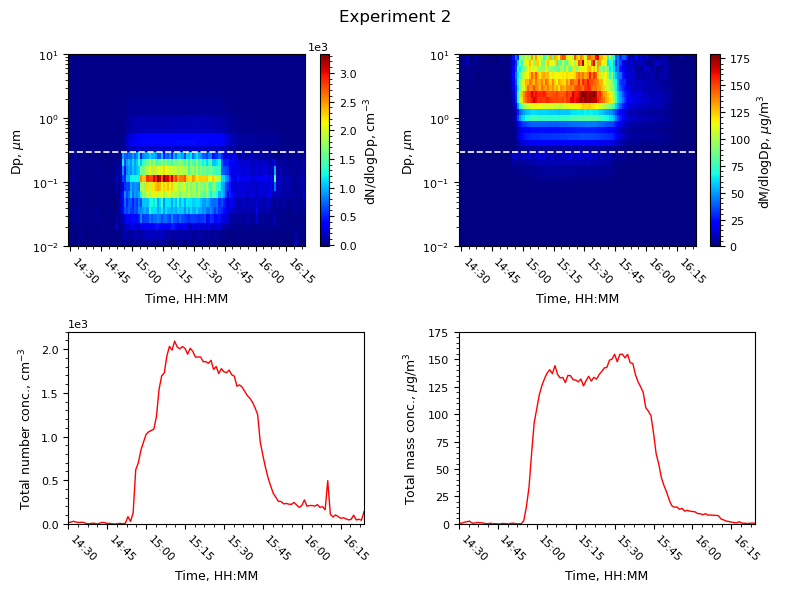

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


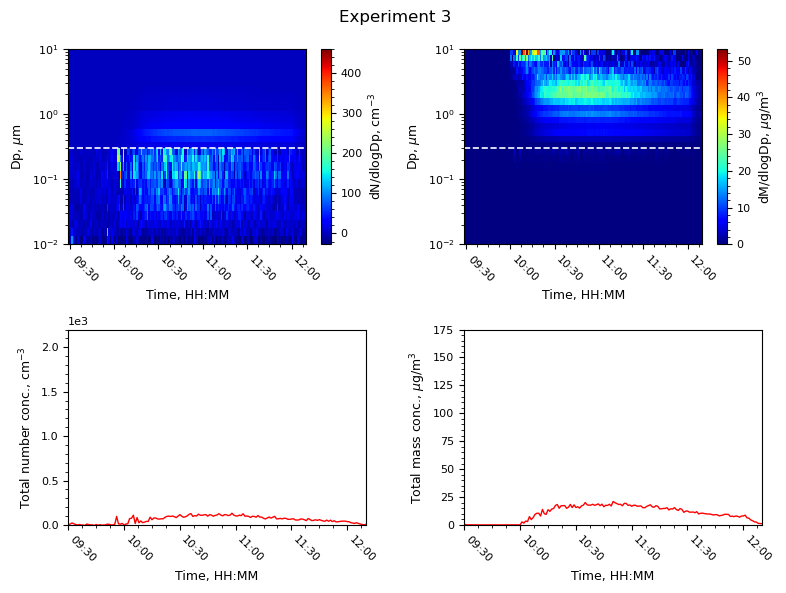

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


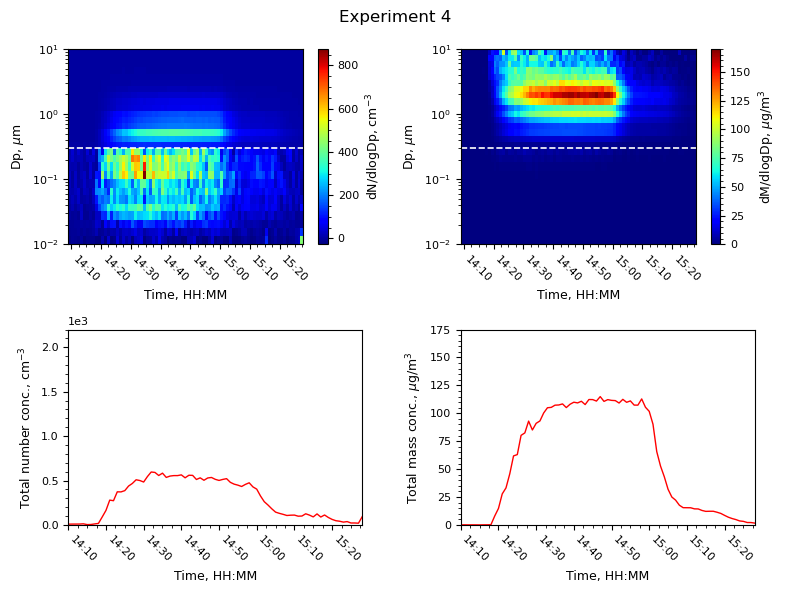

In [12]:
for i, key in enumerate(dict_keys):
    name = 'Timeseries/NS-OPS_timeseries_' + key + '.png'

    fig, ax = plt.subplots(2, 2, figsize = (8, 6))

    plot_timeseries(fig, ax, [NS_OPS_number[key], NS_OPS_mass[key]], NS_OPS_keys, NS_OPS_cut, 'number and mass', time_wBG[i], False, [0.3, 'NanoScan', 'OPS'])

    ax[1][0].set_ylim(0, 2200)
    ax[1][1].set_ylim(0, 175)

    title = 'Experiment ' + str(i + 1)
    fig.suptitle(title)

    fig.tight_layout()
    fig.savefig(name, dpi = 600)
    plt.show()